# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [355]:
import pandas as pd
import psycopg2
from psycopg2 import Error
import requests as re
from scipy import stats
from matplotlib import pyplot
import numpy as np
import datetime
from sklearn.preprocessing import OneHotEncoder
from collections import Counter, OrderedDict
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [402]:
#dataframe with 10,000 results per month to use for modelling, this df has weather data already from weather testing notebook
main_df = pd.read_csv("C:/Users/zain_/LHL/Midterm/mid-term-project-I/main_df.csv")

In [5]:
#cant use dep_delay, or any of the delays really directly

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [ ]:
#take average of all types of delays and add it up to predict delay PER AIRLINE? 
#get airline delay per month per airport?
#dep time to see airport traffic?

In [403]:
#deal with nulls in main_df
main_df = main_df.fillna(value=0)

In [404]:
#drop cancelled flights
main_df = main_df.drop(main_df[main_df.cancelled == 1].index)

In [406]:
#getting mean delay for each airline at each airport
avg_delay_perport = main_df.groupby(['origin','mkt_carrier'])['dep_delay'].mean().reset_index()

In [405]:
#creating a variable with which to link dataframes
main_df['airport_origin'] = main_df.origin+'_'+main_df.mkt_carrier

In [407]:
#creating a variable with which to link dataframes
avg_delay_perport['airport_origin'] = avg_delay_perport.origin+'_'+avg_delay_perport.mkt_carrier

In [408]:
#df with average delay per airline per airport
complete_df = pd.merge(main_df, avg_delay_perport, how='inner', on='airport_origin')

In [409]:
#drop columns not needed anymore
complete_df = complete_df.drop(['airport_origin','origin_y','mkt_carrier_y','carrier_delay', 'weather_delay','nas_delay','security_delay','late_aircraft_delay','dep_delay_x'],axis=1)

In [410]:
#complete df now has weather and avg delay for each airline at each origin airport
complete_df = complete_df.rename(columns={'dep_delay_y':'avg_delay', 'origin_x':'origin','mkt_carrier_x':'mkt_carrier'})

<AxesSubplot:>

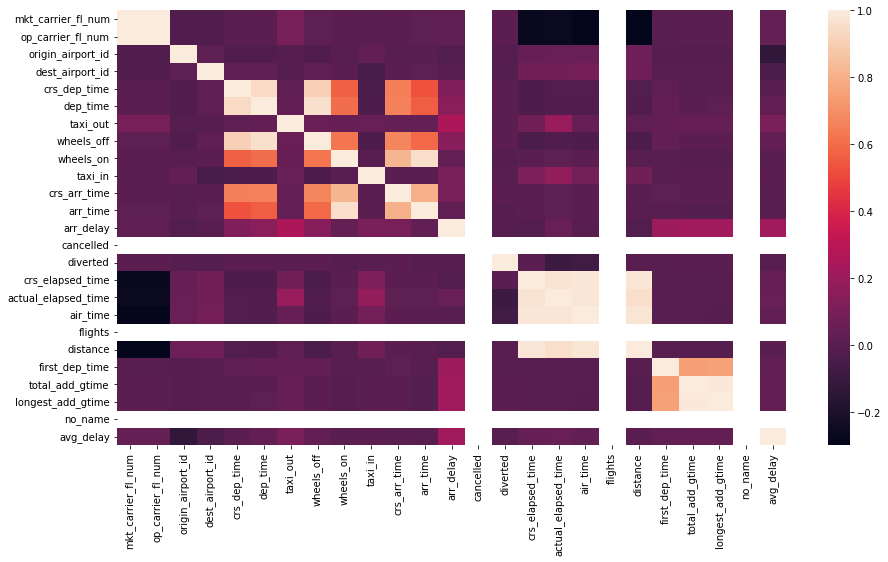

In [411]:
#look at correlations with arrival delay, looking for strong positive and strong negative 
#taxi out has surprisingly high correlation with arr_delay
#can also remove variables that are completely correlated (remove1)
f, ax = plt.subplots(figsize=(15, 8))
corr = complete_df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [412]:
#drop useless or highly correlated columns, keeping the one more correlated with arr_delay
complete_df = complete_df.drop(['no_name','flights','op_carrier_fl_num', 'wheels_on','wheels_off','crs_elapsed_time','air_time','crs_dep_time','crs_arr_time','dup','cancelled'],axis=1)

<AxesSubplot:>

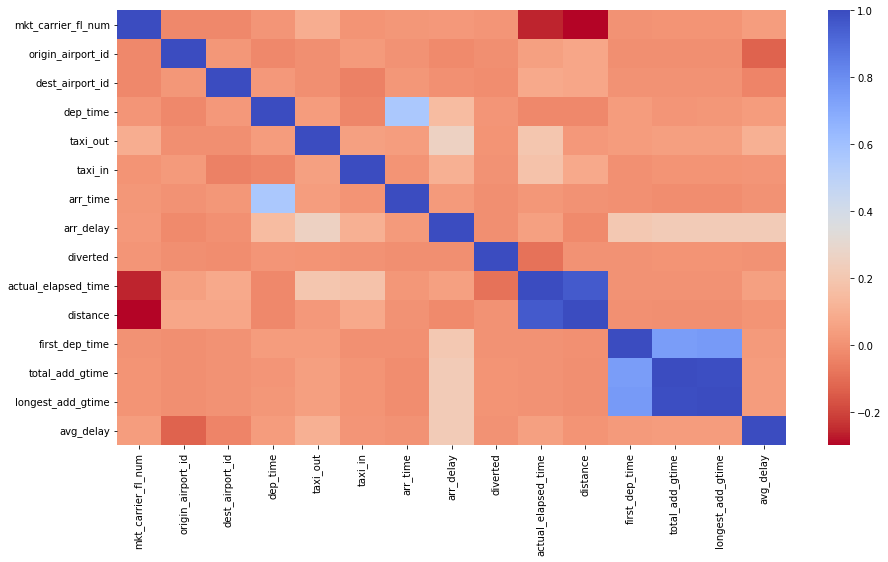

In [413]:
#check correlation matrix after dropping columns
#better heatmap coloring
f, ax = plt.subplots(figsize=(15, 8))
corr = complete_df.corr()
sns.heatmap(corr,
            cmap='coolwarm_r',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [419]:
#drop more, including columns that shouldnt make a difference 
complete_df = complete_df.drop(['longest_add_gtime','distance','mkt_carrier_fl_num','tail_num','branded_code_share','op_unique_carrier','origin_airport_id','dest_airport_id','cancellation_code',],axis=1)

In [420]:
complete_df['fl_date'] = pd.to_datetime(complete_df['fl_date'], format = '%Y-%m-%d')

In [421]:
#checking that these 2 are the same, then dropping one
complete_df[complete_df['mkt_unique_carrier']!=complete_df['mkt_carrier']]
complete_df = complete_df.drop('mkt_unique_carrier',axis=1)

In [423]:
#onehotencode mkt_carrier, concat to the df
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb_carrier =lb.fit(complete_df['mkt_carrier'])
transformed = lb_carrier.transform(complete_df['mkt_carrier'])
ohe_df = pd.DataFrame(transformed)
completed_df =pd.concat([complete_df, ohe_df], axis=1).drop(['mkt_carrier'], axis=1)

In [449]:
#count dep_time as air traffic
completed_df['count_1']=1
traffic_by_deptime = completed_df.groupby(['dep_time'])['count_1'].count().reset_index()
traffic_added_df = pd.merge(completed_df, traffic_by_deptime, how='inner', on='dep_time')

In [450]:
#delete useless count and rename column
#traffic column now represents air traffic
#this would be better if it added all the flights currently in the air up and dropped ones that had landed, if theres time do this
traffic_added_df = traffic_added_df.drop('count_1_x',axis=1)   
traffic_added_df = traffic_added_df.rename(columns={'count_1_y':'air_traffic'}) 

In [490]:
#now count for local airport traffic
dep_time_origin_count = completed_df.groupby(['dep_time','origin'])['count_1'].count().reset_index().sort_values('count_1')
dep_time_origin_count['dep_time_origin'] = dep_time_origin_count.dep_time.astype(str)+'_'+dep_time_origin_count.origin
traffic_added_df['dep_time_origin'] = traffic_added_df.dep_time.astype(str)+'_'+traffic_added_df.origin
traffic_added = pd.merge(traffic_added_df, dep_time_origin_count, how='inner', on='dep_time_origin')

In [491]:
traffic_added = traffic_added.drop(['dep_time_origin','dep_time_y','origin_y'],axis=1)
traffic_added = traffic_added.rename(columns={'origin_x':'origin','dep_time_x':'dep_time','count_1':'airport_traffic'})

In [495]:
#dont need name of origin and destination or origin and destination anymore i think, since i have created variables out of them that should be enough
traffic_added = traffic_added.drop(['origin','origin_city_name','dest','dest_city_name'],axis=1)

In [497]:
#need to one hot encode weather_condition,
traffic_added.dtypes

fl_date                datetime64[ns]
dep_time                      float64
taxi_out                      float64
taxi_in                       float64
arr_time                      float64
arr_delay                     float64
diverted                        int64
actual_elapsed_time           float64
first_dep_time                float64
total_add_gtime               float64
weather_condition              object
avg_delay                     float64
0                               int32
1                               int32
2                               int32
3                               int32
4                               int32
5                               int32
6                               int32
7                               int32
8                               int32
9                               int32
air_traffic                     int64
airport_traffic                 int64
dtype: object

In [505]:
conditions = traffic_added['weather_condition']

In [551]:
#broader categories for easier ohe
#will need this later so just make a function
def correcting_weather(weath_list):
    conditions = [x.lower() for x in weath_list]
    adjusted_conditions = []
    for ele in conditions:
        if 'fog' in ele:
            adjusted_conditions.append('mist')
        elif 'rain' in ele:
            adjusted_conditions.append('rain')
        elif 'thunder' in ele:
            adjusted_conditions.append('thunder')
        elif 'snow' in ele:
            adjusted_conditions.append('rain')
        elif 'sunny' in ele:
            adjusted_conditions.append('clear')
        else:
            adjusted_conditions.append(ele)
    return adjusted_conditions

In [550]:
adjusted_conditions = correcting_weather(traffic_added['weather_condition'])

In [530]:
traffic_added['weather_condition'] = adjusted_conditions

In [543]:
lb = LabelBinarizer()
lb_weather = lb.fit(traffic_added['weather_condition'])
transformed = lb_weather.transform(traffic_added['weather_condition'])
ohe_df = pd.DataFrame(transformed, columns = ['w0','w1','w2','w3','w4','w5'])

In [545]:
ready_df = pd.concat([traffic_added, ohe_df], axis=1).drop(['weather_condition'], axis=1)

In [547]:
#should be ready for modeling now
ready_df.dtypes

fl_date                datetime64[ns]
dep_time                      float64
taxi_out                      float64
taxi_in                       float64
arr_time                      float64
arr_delay                     float64
diverted                        int64
actual_elapsed_time           float64
first_dep_time                float64
total_add_gtime               float64
avg_delay                     float64
0                               int32
1                               int32
2                               int32
3                               int32
4                               int32
5                               int32
6                               int32
7                               int32
8                               int32
9                               int32
air_traffic                     int64
airport_traffic                 int64
w0                              int32
w1                              int32
w2                              int32
w3          

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [ ]:
#pca can help reduce noise that the last couple features that dont explain much variance add
#pca is trying to find the direction of the data points kind of, its not as useful for supervised learning
#svd and lda worth considering
#leave this for now

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [553]:
from sklearn.model_selection import train_test_split

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.